In [1]:
import nocap.utility as utility
import mira
import pyciemss
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te

from mira.sources.sbml import template_model_from_sbml_file
import pyciemss
import pyciemss.visuals.plots as plots

print(mira.__version__)

0.5.0


In [37]:
# np.random.seed(0)

# # Initialize a directed graph
# G = nx.DiGraph()

# # Add some nodes (genes)
# genes = ['GeneA', 'GeneB', 'GeneC', 'GeneD', 'GeneE']
# G.add_nodes_from(genes)

# # List of potential edges
# edges = [
#     ('GeneA', 'GeneB'),
#     ('GeneA', 'GeneC'),
#     ('GeneB', 'GeneD'),
#     ('GeneC', 'GeneD'),
#     ('GeneD', 'GeneE')
# ]

# # Add edges with the 'interaction_type' as 'activation' or 'repression'
# for edge in edges:
#     interaction_type = np.random.choice(['activation', 'repression'])
#     G.add_edge(edge[0], edge[1], interaction_type=interaction_type)

np.random.seed(0)

# Initialize a directed graph
G = nx.DiGraph()

# Add some nodes (genes)
genes = ['GeneA', 'GeneB']
G.add_nodes_from(genes)

# List of potential edges
edges = [
    ('GeneA', 'GeneB'),
]

# Add edges with the 'interaction_type' as 'activation' or 'repression'
for edge in edges:
    interaction_type = np.random.choice(['activation', 'repression'])
    G.add_edge(edge[0], edge[1], interaction_type=interaction_type)

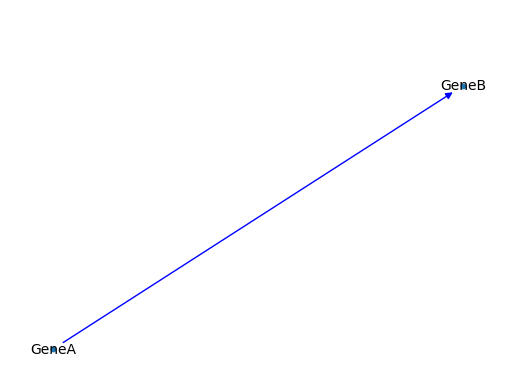

In [38]:
# Plotting the network
pos = nx.spring_layout(G)  # positions for all nodes

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=10)

# Separate edges by interaction type
activation_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'activation']
repression_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'repression']

# Draw edges with different colors for activation and repression
nx.draw_networkx_edges(G, pos, edgelist=activation_edges, edge_color='blue', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=repression_edges, edge_color='red', arrows=True, style='dashed')

# Draw labels for the nodes
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Turn off axis and display the plot
plt.axis('off')
plt.show()



In [39]:
filename = "test_dag.xml"
utility.create_sbml_model_from_nx(G,filename)

Generated Antimony Model:
model grn_model()
  compartment default_compartment = 1;
  species GeneA in default_compartment;
  GeneA = 1;
  species GeneB in default_compartment;
  GeneB = 1;
  J_GeneA_to_GeneB: GeneA => GeneB; beta_GeneA_to_GeneB * GeneA^n_GeneA_to_GeneB / (K_GeneA_to_GeneB^n_GeneA_to_GeneB + GeneA^n_GeneA_to_GeneB);
  beta_GeneA_to_GeneB = 1.0; // units: mole_per_second
  K_GeneA_to_GeneB = 1.0; // units: mole
  n_GeneA_to_GeneB = 1.0; // units: dimensionless
end
SBML model written to test_dag.xml


In [40]:

mira_model = template_model_from_sbml_file(filename)
display(mira_model.parameters)
display(mira_model.initials)


{'beta_GeneA_to_GeneB': Parameter(name='beta_GeneA_to_GeneB', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'n_GeneA_to_GeneB': Parameter(name='n_GeneA_to_GeneB', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'K_GeneA_to_GeneB': Parameter(name='K_GeneA_to_GeneB', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'default_compartment': Parameter(name='default_compartment', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None)}

{'GeneA': Initial(concept=Concept(name='GeneA', display_name='GeneA', description=None, identifiers={}, context={}, units=None), expression=1.0),
 'GeneB': Initial(concept=Concept(name='GeneB', display_name='GeneB', description=None, identifiers={}, context={}, units=None), expression=1.0)}

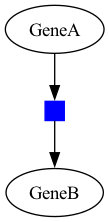

In [41]:
from mira.modeling.ode import OdeModel
from mira.modeling.viz import GraphicalModel

GraphicalModel.for_jupyter(mira_model)

In [42]:
from mira.modeling.ode import OdeModel
from mira.modeling import Model
om = OdeModel(Model(mira_model), initialized=True)
om.get_interpretable_kinetics()


Matrix([
[-GeneA**n_GeneA_to_GeneB*beta_GeneA_to_GeneB/(GeneA**n_GeneA_to_GeneB + K_GeneA_to_GeneB**n_GeneA_to_GeneB)],
[ GeneA**n_GeneA_to_GeneB*beta_GeneA_to_GeneB/(GeneA**n_GeneA_to_GeneB + K_GeneA_to_GeneB**n_GeneA_to_GeneB)]])

In [27]:
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model
from pathlib import Path

petrinet_model_filename = 'test_petrinet.json'
file_root = Path(petrinet_model_filename).stem
petrinet_model = AMRPetriNetModel(Model(mira_model))
petrinet_model.to_json_file(
                petrinet_model_filename,
                name=file_root,
                description=file_root,
                indent=2,
            )

In [28]:
start_time = 0.0
end_time = 1
logging_step_size = 0.1
num_samples = 3

petrinet_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, start_time=start_time)
display(petrinet_results['data'].head())
print(petrinet_results.keys())

,timepoint_id,sample_id,timepoint_unknown,GeneA_state,GeneB_state,GeneC_state
0,0,0,0.0,1.0,1.000000,1.000000
1,1,0,0.1,0.9,1.048707,1.051293
2,2,0,0.2,0.8,1.094640,1.105361
3,3,0,0.3,0.7,1.137481,1.162519
4,4,0,0.4,0.6,1.176856,1.223144


dict_keys(['data', 'unprocessed_result', 'risk'])


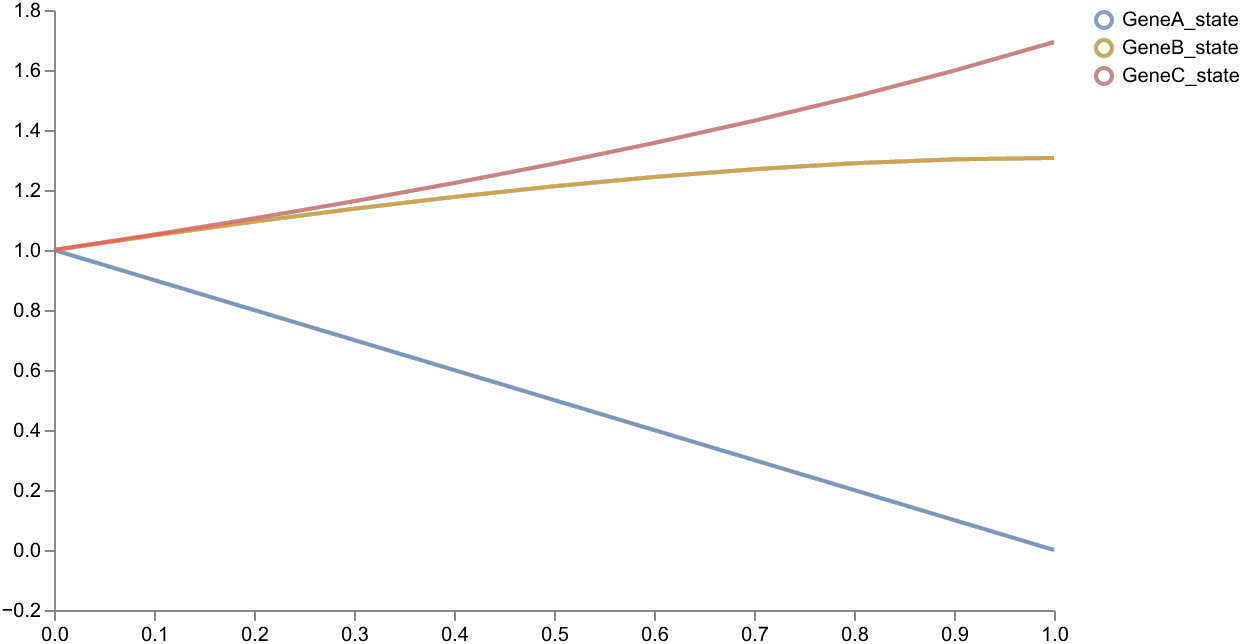

In [29]:
# Plot results for all states
schema = plots.trajectories(petrinet_results["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [31]:
## for priors use uniform(0,1)

from mira.metamodel import Distribution


dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 0.5,"maximum": 1.5 }     
                     )

for name,parameter in mira_model.parameters.items():
    if name != "default_compartment":
        parameter.distribution = dist

petrinet_model_filename = 'test_petrinet_w_priors.json'
file_root = Path(petrinet_model_filename).stem
petrinet_model = AMRPetriNetModel(Model(mira_model))
petrinet_model.to_json_file(
                petrinet_model_filename,
                name=file_root,
                description=file_root,
                indent=2,
            )

In [32]:
rr_model = te.loadSBMLModel(filename)
rr_results = rr_model.simulate(0,1)

In [33]:
import pandas as pd    

data_filepath = "test_data.csv"
formatted_df = pd.DataFrame(rr_results, columns=rr_results.colnames)
formatted_df = formatted_df.set_index('time')
formatted_df.index.names = ['Timestamp']  # must be 'Timestamp' for pyciemss

formatted_df.columns = formatted_df.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)
formatted_df.to_csv(data_filepath)

formatted_df.head()


,GeneA,GeneB,GeneC
Timestamp,,,
0.00,1.00,1.000000,1.000000
0.02,0.98,1.009948,1.010052
0.04,0.96,1.019796,1.020204
0.06,0.94,1.029539,1.030461
0.08,0.92,1.039175,1.040825


In [35]:
num_iterations = 100
data_to_use = formatted_df
data_path = data_filepath
model_path_or_json = petrinet_model_filename

data_mapping = {k:k for k in data_to_use.columns}  # remove '[]' for concentration added by Tellurium
print(data_mapping)
calibration_results = pyciemss.calibrate(model_path_or_json, data_path, data_mapping=data_mapping, num_iterations=num_iterations, verbose=True)

/Users/geor228/miniconda3/envs/NOCAP_env/lib/python3.11/site-packages/pyciemss/integration_utils/observation.py:49: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: calibrate

                Function docs : 
    Infer parameters for a DynamicalSystem model conditional on data.
    This uses variational inference with a mean-field variational family to infer the parameters of the model.

    Args:
        - model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        - data_path: str
            - A path to the data file.
        - data_mapping: Dict[str, str]
            - A mapping from column names in the data file to state variable names in the model.
                - keys: str name of column in dataset
                - values: 

{'GeneA': 'GeneA', 'GeneB': 'GeneB', 'GeneC': 'GeneC'}
Data printout: This dataset contains 50 rows of data. The first column, Timestamp, begins at 0.0 and ends at 1.0. The subsequent columns are named: GeneA, GeneB, GeneC


AssertionError: underflow in dt 0.0

In [19]:
parameter_estimates = calibration_results["inferred_parameters"]
parameter_estimates()

{'persistent_K_GeneA_to_GeneB': tensor(1.1156, grad_fn=<ExpandBackward0>),
 'persistent_beta_GeneA_to_GeneB': tensor(1.0060, grad_fn=<ExpandBackward0>),
 'persistent_n_GeneA_to_GeneB': tensor(0.8434, grad_fn=<ExpandBackward0>)}

In [20]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 1
logging_step_size = 0.1	#1.0
num_samples = 10

calibrated_sample_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

,timepoint_id,sample_id,timepoint_unknown,persistent_K_GeneA_to_GeneB_param,persistent_beta_GeneA_to_GeneB_param,persistent_n_GeneA_to_GeneB_param,GeneA_state,GeneB_state
0,0,0,0.0,0.756946,0.85227,0.960299,1.000000,1.000000
1,1,0,0.1,0.756946,0.85227,0.960299,0.952213,1.047787
2,2,0,0.2,0.756946,0.85227,0.960299,0.905431,1.094569
3,3,0,0.3,0.756946,0.85227,0.960299,0.859687,1.140313
4,4,0,0.4,0.756946,0.85227,0.960299,0.815013,1.184987


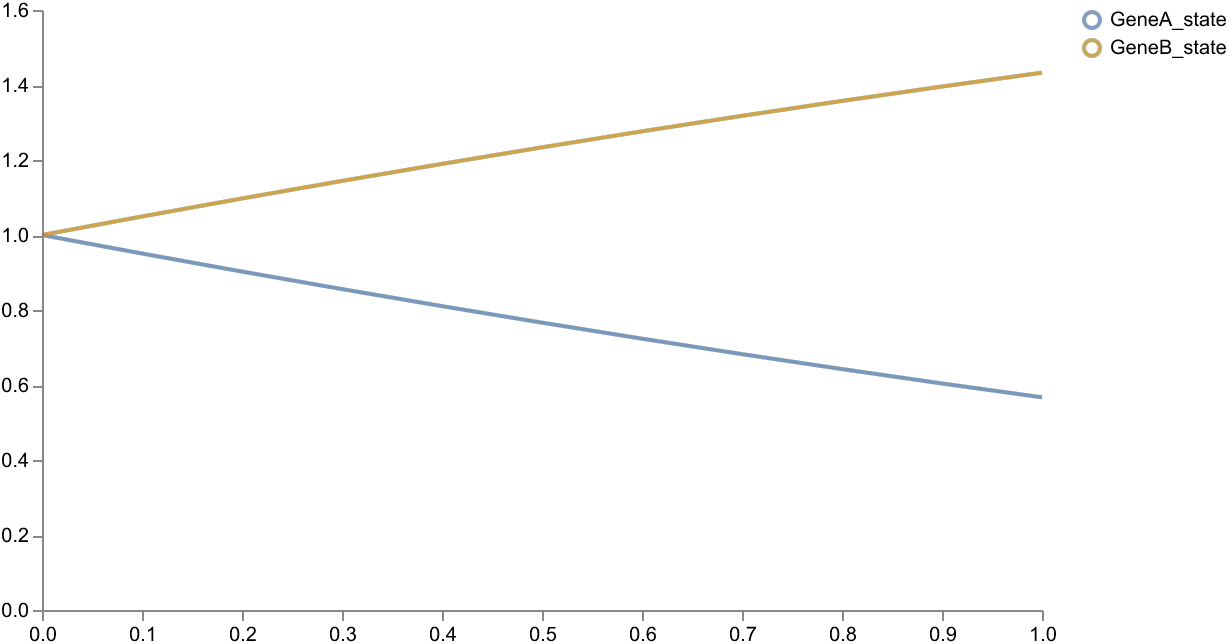

In [21]:
# Plot results for all states
schema = plots.trajectories(petrinet_results["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)